In [0]:
import numpy as np
import gym
from gym import wrappers
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

In [0]:
class Policy(nn.Module):
  def __init__(self,input_shape, action_space):
    super(Policy, self).__init__()
    
    self.pi = nn.Sequential(
                              nn.Linear(input_shape,256),
                              nn.ReLU(),
                              nn.Linear(256, action_space),
                              nn.Softmax(dim = 1)
                            )
    
  def forward(self, x):
    x = self.pi(x)
    dist = Categorical(x)
    action = dist.sample()
    logprob = dist.log_prob(action)
    return action, logprob

In [0]:
def test_current_model():
    state = env.reset()
    
    done = False
    total_reward = 0
    while not done:
        #env.render()
        state = torch.FloatTensor(state).unsqueeze(0)
        action, _ = pi(state)
        next_state, reward, done, _ = env.step(action.numpy()[0])
        state = next_state
        total_reward += reward
    env.reset()
    return total_reward
  

In [0]:
def calc_discounted_rewards(rewards, final_state, gamma = 0.99):
  R = 0
  discounted = []
  
  for idx in reversed(range(len(rewards))):
    R = rewards[idx]+R*gamma *final_state[idx]
    discounted.insert(0,R)
  return discounted

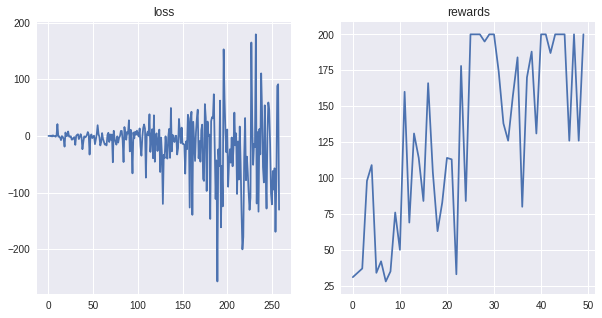

In [7]:

env = gym.make("CartPole-v0") 
input_shape = env.observation_space.shape[0]
action_space = env.action_space.n

frame_idx = 0
max_frames = 25000

pi = Policy(input_shape=input_shape, action_space= action_space)
optimizer = optim.Adam(pi.parameters(),lr = 0.001)

total_rewards = []
total_loss = []



while frame_idx < max_frames:
  
  log_probs = []
  rewards = []
  final_state = []
  done = False
  state = env.reset()
  
  while not done:
    state_v = torch.FloatTensor(state)

    action, log_prob = pi(state_v.unsqueeze(0))
    new_state, reward, done, _ = env.step(action.item())
    
    log_probs.append(log_prob)
    rewards.append(torch.FloatTensor(np.array([reward])))
    final_state.append(torch.FloatTensor(np.array([1-done])))
    
    state = new_state
    frame_idx += 1
    
      
    if frame_idx % 500 == 0:
      total_reward = test_current_model()
      total_rewards.append(total_reward)

  
  discounted_rewards = torch.FloatTensor(calc_discounted_rewards(rewards, final_state))
  baseline = discounted_rewards.mean()
  loss = (-torch.cat(log_probs)*(discounted_rewards-baseline)).sum()
  total_loss.append(loss)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.title("loss")
plt.plot(total_loss)
plt.subplot(1,2,2)
plt.title("rewards")
plt.plot(total_rewards)